### This notebook can be run directly on Colab,it consists of the following components:


1.   Define a time-dependent score model
2.   Set up the SDE to use, specify the drift, diffusion coefficient function, and compute the corresponding marginal distribution function
3.   Define the loss function for the score matching
4.   Build the training function
5.   Define samplers: Euler-Maruyama, pc_sampler, ODE_sampler
6.   Comparing sampling results

### Define a time-dependent score model

The backbone of this model is a classical U-net with skip connections

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Time_embedding(nn.Module):
  """Gaussian random features for embedding time."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, t):
    t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

class Dense(nn.Module):
  '''
  A fully connected layer that reshapes the time embedding to match the feature maps
  '''
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
  '''
  A time-dependent score-based model built upon a classical U-Net with skip connections.
  '''

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    '''
    Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the transition kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of time embeddings.
    '''
    super().__init__()
    # Embedding layer for time
    self.embed = nn.Sequential(Time_embedding(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h







Choose the following SDE
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1].
\end{align*}
In this case,
\begin{align*}
p_{0t}\left\{\mathbf{x}(t) \mid \mathbf{x}(0)\right\} = \mathcal{N}\left\{\mathbf{x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) \mathbf{I}\right\}.
\end{align*}
This choice of SDE corresponds to SBGM with the level of noise as $\Sigma=\frac{1}{2\log \sigma}\ (\sigma^{2t}-1) \mathbf{I}$, in the following, choose $\sigma=25$, then the noise level increases as $t$ increases from 0 to 1. When $t=1$, the distribution $p_T$ is almost completely noise adn independent of the data distribution.

Remark: by the SDEs which govern the mean and variacne, since the drift is 0. Then
\begin{align*}
\frac{d\mathbf{m}}{dt}&=0,\\
\frac{dP}{dt}&=\sigma^{2t}\mathbf{I}.
\end{align*}
So that SDEs we can directly get the mean and covariance for the transition kernel which is crucial for speed computation.

### Set up the SDE

In [ ]:
from numpy.lib.function_base import diff
import functools
device = "cuda" if torch.cuda.is_available() else "cpu"

def marginal_prob_std(t,sigma):
  '''
  Compute standard deviation of transition kernal

  Args:
    t: A vector of time steps
    sigma: the \sigma in our SDE

  '''
  t = torch.tensor(t,device=device)
  return torch.sqrt((sigma**(2*t)-1.) / (2. * np.log(sigma)))

def diffusion_coeff(t, sigma):
  '''
  Compute the diffusion coefficient of our SDE

  Args:
    t: A vector of time steps
    sigma: the \sigma in our SDE
  '''
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Define loss function

The loss function is
\begin{align*}
&\mathbb{E}_{{x(0)}\sim p_0(x),x(t)\sim p_{0t}\ (x(t)|x(0)}\quad \quad \lambda(t)^2 \left\|s_{\theta}(x_t,t)-\nabla_{x(t)}\log p_{0t}\{x(t)|x(0)\}\right\|^2\\
&=\mathbb{E}_{{x(0)}\sim p_0(x),x(t)\sim p_{0t}\ (x(t)|x(0)}\quad \quad\lambda(t)^2\left\|s_{\theta}(x_t,t)+\frac{1}{\lambda^2(t)}\{x(t)-x(0)\}\right\|^2\\
&=\mathbb{E}_{{x(0)}\sim p_0(x),x(t)\sim p_{0t}\ (x(t)|x(0)}\quad \quad\lambda(t)^2\left\|s_{\theta}(x_t,t)+\frac{1}{\lambda(t)}z\right\|^2\\
&=\mathbb{E}_{{x(0)}\sim p_0(x),x(t)\sim p_{0t}\ (x(t)|x(0)}\quad \quad \left\|\lambda(t)s_{\theta}(x_t,t)+z\right\|^2.
\end{align*}
Here $\lambda(t)$ is the standard deviation of the transition kernel, i.e., $\lambda^2(t)=\frac{1}{2\log\sigma}\ \ (\sigma^{2t}-1)$, and we sample $x(t)$ by $x(t)=x(0)+\lambda(t)z$, and $z$ follows standard Gaussian. Hence the loss function for each sample is $\|\lambda(t)s_{\theta}(x_t,t)+z\|^2$.

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  '''
  The loss function for training the score model

  Args:
    model: a PyTorch model instance that represents a time-dependent score model.
    x: a mini-batch of training data.
    marginal_prob_std: a function that gives the standard deviation of the transition kernel.
    eps: a tolerance value for numerical stability.

  '''
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  xt = x + z * std[:, None, None, None]
  score = model(xt, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Training

In [ ]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-43933e138967>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,device=device)


### Sampling with numerical SDE solvers
- Approximate the reverse SDE with the score model and simulate the reverse-time SDE by numerical methods such as Euler-Maruyama approach.

Recall that for any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w},
\end{align*}
the reverse-time SDE is given by
\begin{align*}
d \mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}}.
\end{align*}
For the sde we choose in our experiment
\begin{align*}
d \mathbf{x}=\sigma^td \mathbf{w},\ t\in[0,1]
\end{align*}
The reverse SDE is given by
\begin{align*}
d\mathbf{x} = -\sigma^{2t}\nabla_x\log p_t(x)dt + \sigma^t d\bar{\mathbf{w}}
\end{align*}
Using our time-dependent score modek, the reverse-time SDE can be approxiamted by
\begin{align*}
d\mathbf{x}=-\sigma^{2t}s_{\theta}(\mathbf{x},t)+\sigma^td\bar{\mathbf{w}}
\end{align*}
Next, one can use numerical methods to solve the reverse-time SDE such as the Euler-Maruyama approach. It is based on a simple discritization to the SDE, replacing $dt$ with $\Delta t$ and $d\mathbf{w}$ with $z\sim\mathcal{N}(0,\Delta t \mathbf{I})$. When applied to our reverse-time SDE, we obtain the following iteration rule
\begin{align*}
x = x_t + \sigma^{2t}s_{\theta}(\mathbf{x},t)\Delta t + \sigma^t\sqrt{\Delta t}\mathbf{z}_t,
\end{align*}
where $\mathbf{z}_t\sim\mathcal{N}(\mathbf{0},\mathbf{I})$.

### Define the Euler-Maruyama sampler

In [ ]:
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3):
  '''
  Generate samples from score model with Euler-Maruyama predictor

  Args:
    score_model: a PyTorch model that represents the time-dependent score model
    marginal_prob_std: a function that gives the standard deviation of the transition kernel p_{0t}(x(t)|x(0))
    diffusion_coeff: a function that gives the diffusion coefficient of the SDE
    batch_size:the number of samples in each batch
    eps: the smallest time step for numerical stability

  Returns: samples.
  '''
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

### Sampling with Predictor-Corrector methods


Since we have an estimate of the score of $p_t(\mathbf{x}(t))$ via the score-based model, i.e., $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_t(\mathbf{x}(t))$, we can leverage score-based MCMC approaches, such as Langevin MCMC, to correct the solution obtained by numerical SDE solvers.

Score-based MCMC approaches can produce samples from a distribution $p(\mathbf{x})$ once its score $\nabla_\mathbf{x} \log p(\mathbf{x})$ is known. For example, Langevin MCMC operates by running the following iteration rule for $i=0,1,\cdots, N$:
\begin{align*}
\mathbf{x}_{i+1} = \mathbf{x}_{i} + \epsilon \nabla_\mathbf{x} \log p(\mathbf{x}_i) + \sqrt{2\epsilon} \mathbf{z}_i,
\end{align*}
where $\mathbf{z}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $\epsilon > 0$ is the step size, and $\mathbf{x}_0$ is initialized from any prior distribution $\pi(\mathbf{x}_0)$. When $N\to\infty$ and $\epsilon \to 0$, the final value $\mathbf{x}_{N+1}$ becomes a sample from $p(\mathbf{x})$ under some regularity conditions. Therefore, given $s_\theta(\mathbf{x}, t) \approx \nabla_\mathbf{x} \log p_t(\mathbf{x})$, we can get an approximate sample from $p_t(\mathbf{x})$ by running several steps of Langevin MCMC, replacing $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ with $s_\theta(\mathbf{x}, t)$ in the iteration rule.

**Predictor**: simulate reverse-time SDE, apply one-step numerical solver to obtain $x_{t-\Delta t}\ $  from $x_t$.

**Corrector**: apply several steps of Langevin MMC to refine $x_t$, such that $x_t$ becomes a more accurate sample from $p_{t-\Delta t}\ (\mathbf{x})$. This steps helps refuce the error of the numerical SDE solver.

In [ ]:
signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3,
               denoise=True):
  '''
  Generate samples from score model with Predictor-Corrector method

  Args:
    score_model: a PyTorch model that represents the time-dependent score model
    marignal_prob_std: a function that gives the standard deviation of transition kernel
    diffusion_coeff: a function that gives the diffusion coefficient of the SDE
    num_steps: the number of sampling steps
    eps: the smallest time step for numerical stability
    denoise: if true, add a denoising step in the last step, i.e., the last step do not include any noise

  '''
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean if denoise else x

### Sampling with numerical ODE solver

For any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}
there exists an associated ordinary differential equation (ODE)
\begin{align*}
d \mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt,
\end{align*}
such that their trajectories have the same mariginal probability density $p_t(\mathbf{x})$. Therefore, by solving this ODE in the reverse time direction, we can sample from the same distribution as solving the reverse-time SDE.
We call this ODE the *probability flow ODE*.

Below is a schematic figure showing how trajectories from this probability flow ODE differ from SDE trajectories, while still sampling from the same distribution.
![SDE and ODE](https://drive.google.com/uc?id=1CGFbtY2mCjlIY8pjvoGevfa_32d4b1dj)

Therefore, we can start from a sample from $p_T$, integrate the ODE in the reverse time direction, and then get a sample from $p_0$. In particular, for the SDE in our running example, we can integrate the following ODE from $t=T$ to $0$ for sample generation
\begin{align*}
d\mathbf{x} =  -\frac{1}{2}\sigma^{2t} s_\theta(\mathbf{x}, t) dt.
\end{align*}
This can be done using many black-box ODE solvers provided by packages such as `scipy`.

In [ ]:
from scipy import integrate

err_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=err_tolerance,
                rtol=err_tolerance,
                device="cuda",
                z=None,
                eps=1e-3,
                denoise=True):
  '''
  Generate samples from score model with black-box ODE solvers

  Args:
    score_model: a PyTorch model that represents the time-dependent score model.
    marignal_prob_std: a function that gives the standard deviation of transition kernel.
    diffusion_coeff: a function that gives the diffusion coefficient of the SDE.
    num_steps: the number of sampling steps.
    atol: tolerance of absolute errors.
    rtol: tolerance of relative errors.
    z: the latent code that governs the final sample. If None, we start from p_0, otherwise,
      we start from the given z.
    eps: the smallest time step for numerical stability.

  '''
  t = torch.ones(batch_size,device=device)
  if not z:
    init_x = torch.randn(batch_size,1,28,28,device=device) * marginal_prob_std(t)[:,None,None,None]
  else:
    init_x = z

  shape = init_x.shape
  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)


  def ode_func(t,x):
    '''
    The ODE function for use by the ODE solver
    '''
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return -0.5 * (g**2) * score_eval_wrapper(x,time_steps)

  def denoising(x):
    num_steps = 500
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    batch_time_step = torch.ones(batch_size, device=device) * eps
    g = diffusion_coeff(batch_time_step)
    x_mean = x + ((g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size).to(dtype=x.dtype)
    return x_mean

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape).float()
  if denoise:
    x = denoising(x)
  return x

<ipython-input-2-43933e138967>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,device=device)
<ipython-input-2-43933e138967>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 332


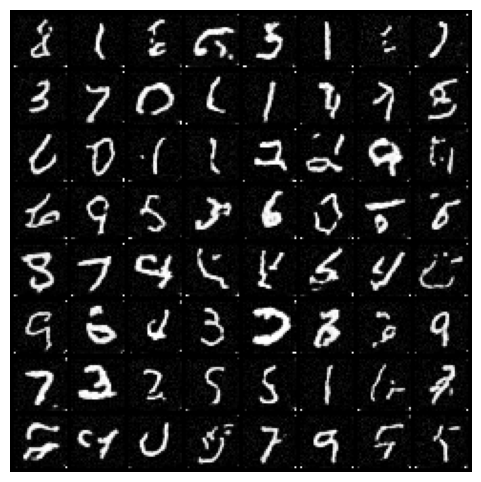

In [ ]:
#Sampling with ode sampler (denoise=True)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                  denoise=True)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

<ipython-input-2-43933e138967>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,device=device)
<ipython-input-2-43933e138967>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 332


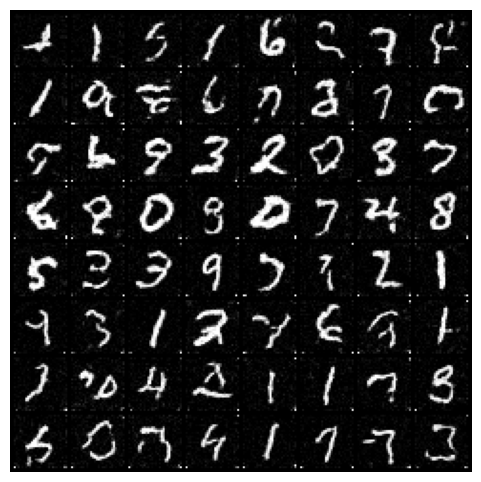

In [ ]:
#Sampling with ode sampler (denoise=False)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                  denoise=False)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

<ipython-input-2-43933e138967>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-2-43933e138967>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


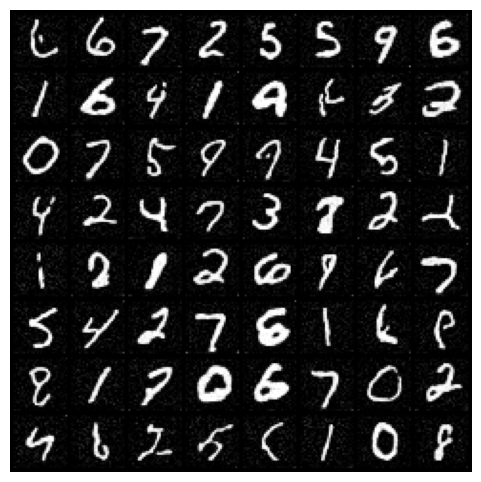

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                  denoise=True)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

<ipython-input-2-43933e138967>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-2-43933e138967>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


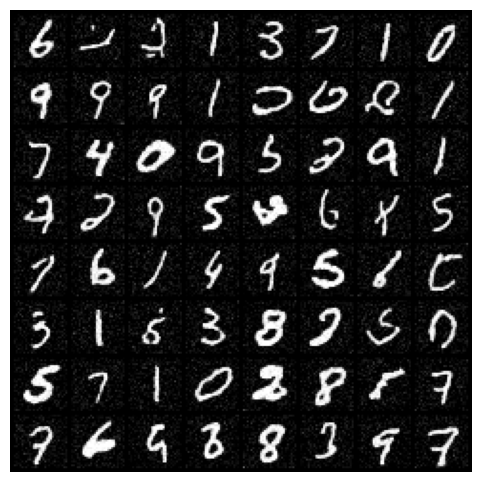

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                  denoise=False)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

<ipython-input-2-43933e138967>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-2-43933e138967>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


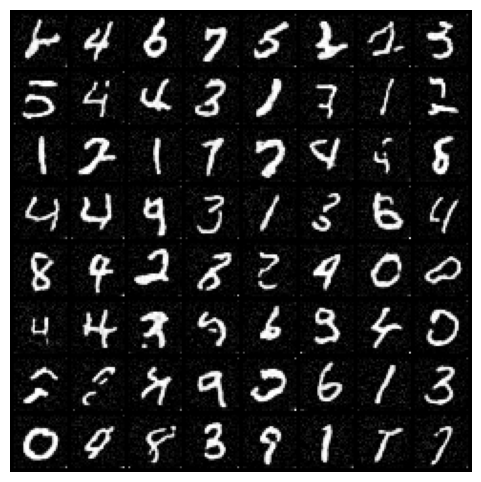

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

### Observation:


1.   Among three types of samplers (ODE, EU, PC), PC sampler gives the best results, while the sampling quality for ODE sampler is not desirable
2.   From page 3 in this paper https://arxiv.org/pdf/2006.09011.pdf and in the ICLR21 paper, adding a denosing in the end using Tweedie's formula can improve FID score, but the visual difference  is not significant
3.   When implementing the single step of denoising in the end of sampling, this note follows the implementation of ICLR21 Github repo https://github.com/yang-song/score_sde_pytorch/tree/main, that is, do not include Gaussian noise in the last prediction step (reversing the SDE).

